In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = (11, 5)
pd.options.mode.chained_assignment = None  # default='warn'

Leemos el fichero de disco, obtenido mediante una API interna del sistema de monitorización.

In [48]:
df = pd.read_csv('/home/mhuertas/.cache/webreport/following_error_2021_03/merge_samples.gz',dtype={"OE.ObservingEngine.currentObservingState": "string"})

Existen muchos valores NaN ya que no todos los monitores se samplean a la misma frecuencia, por lo que para un mismo instante no tenemos valores para todos los monitores. Tambien cambiamos el orden de las columnas

In [49]:
df = df.fillna(method='ffill')
df = df.dropna()

column_names=['TimeStampLong',\
              'MACS.AzimuthAxis.position',\
              'MACS.AzimuthAxis.followingError',\
              'MACS.ElevationAxis.position',\
              'OE.ObservingEngine.currentObservingState',\
              'OE.ObservingEngine.slowGuideErrorA',\
              'OE.ObservingEngine.slowGuideErrorB',\
              'ECS.DomeRotation.actualPosition',\
              'ECS.UpperShutter.actualPosition',\
              'EMCS.WeatherStation.meanWindSpeed',\
              'EMCS.WeatherStation.windDirection'
              ]
df = df.reindex(columns=column_names)

Convertios el following error de radians to arc/sec. Un valor de 0.1 arc/sec en 1 px en detecor, lo que significa que un following error < 0.1 no es significativo de problemas. Por otro lado, con el following error es neceario normalizarlo con el coseno de la elevación. Realmente es con el coseno de la declinación (TODo incluir declinación).

In [50]:
def normalize_following_error(following_error, elevation):
    return following_error * 3600

df['MACS.AzimuthAxis.followingError'] = df.apply(
    lambda row: normalize_following_error(row['MACS.AzimuthAxis.followingError'], row['MACS.ElevationAxis.position']),
    axis=1)

Filtramos valores por rangos válidos, para eliminar incorrectos:

MACS.AzimuthAxis.position [0,360] degrees
MACS.ElevationAxis.position [0,90] degrees
ECS.DomeRotation.actualPosition [0,360] degrees
ECS.UpperShutter.actualPosition [0,90] degrees
EMCS.WeatherStation.windDirection [0,360] degrees
EMCS.WeatherStation.meanWindSpeed [0,100] m/s

TODO check following error correct ranges
Vamos a limitir el estudio (TBC) a valores de following error entre [0,10] En following de 10 son 100 px en detector, valores mayores pueden ser espureos.

In [51]:
df = df[ (df['MACS.AzimuthAxis.position'] >= -180 ) & ( df['MACS.AzimuthAxis.position'] <= 360 ) ]
df = df[ (df['MACS.ElevationAxis.position'] >= 0 ) & ( df['MACS.ElevationAxis.position'] <= 90 ) ]
df = df[ (df['ECS.DomeRotation.actualPosition'] >= 0 ) & ( df['ECS.DomeRotation.actualPosition'] <= 360 ) ]
df = df[ (df['ECS.UpperShutter.actualPosition'] >= 0 ) & ( df['ECS.UpperShutter.actualPosition'] <= 90 ) ]
df = df[ (df['EMCS.WeatherStation.windDirection'] >= 0 ) & ( df['EMCS.WeatherStation.windDirection'] <=360 ) ]
df = df[ (df['EMCS.WeatherStation.meanWindSpeed'] >=0 ) & ( df['EMCS.WeatherStation.meanWindSpeed'] <=100 ) ]
df = df[ (df['MACS.AzimuthAxis.followingError'] >=-10 ) & ( df['MACS.AzimuthAxis.followingError'] <=10 ) ]

Normalizamos azimuth, ya que posisiones equivalentes para mirar orientacion de viento.

In [52]:
def normalize_azimuth(angle):
    return angle % 360

df['MACS.AzimuthAxis.position'] = df.apply(
    lambda row: normalize_azimuth(row['MACS.AzimuthAxis.position']),
    axis=1)


Miramos los valores para hacernos una idea general

In [53]:
df.describe()

,MACS.AzimuthAxis.position,MACS.AzimuthAxis.followingError,MACS.ElevationAxis.position,OE.ObservingEngine.slowGuideErrorA,OE.ObservingEngine.slowGuideErrorB,ECS.DomeRotation.actualPosition,ECS.UpperShutter.actualPosition,EMCS.WeatherStation.meanWindSpeed,EMCS.WeatherStation.windDirection
count,1.559370e+06,1.559370e+06,1.559370e+06,1.559370e+06,1.559370e+06,1.559370e+06,1.559370e+06,1.559370e+06,1.559370e+06
mean,1.855467e+02,2.665308e-02,5.259718e+01,-8.199964e-07,-2.754119e-06,1.850512e+02,7.463632e+01,6.511222e+00,1.945124e+02
std,1.209286e+02,2.027134e+00,1.688687e+01,1.191428e-05,2.820683e-05,1.214817e+02,3.109201e+01,3.049951e+00,6.730616e+01
min,8.860737e-03,-9.999999e+00,0.000000e+00,-9.430900e-05,-5.345080e-04,0.000000e+00,0.000000e+00,3.850889e-01,0.000000e+00
25%,7.738614e+01,-5.308110e-02,4.162437e+01,-1.983797e-07,-1.824905e-07,7.284800e+01,8.769270e+01,4.231511e+00,1.540000e+02
50%,1.880014e+02,0.000000e+00,5.479336e+01,0.000000e+00,0.000000e+00,1.870180e+02,8.793780e+01,6.277033e+00,1.740000e+02
75%,3.188388e+02,5.338499e-02,6.320413e+01,1.728829e-07,2.383133e-07,3.194950e+02,8.794900e+01,8.655033e+00,2.340000e+02
max,3.599925e+02,9.999187e+00,8.999769e+01,9.082496e-04,1.698503e-05,3.599990e+02,8.795200e+01,1.520687e+01,3.590000e+02


En el análisis solo nos interesa cuando se estaba observando y con el telescopio siguiendo a objetos, filtramos aquellas condiciones en que no se esta observando no se está siguiendo objeto.

In [54]:
df['OE.ObservingEngine.currentObservingState'].value_counts()

GUIDING     891637
OFF         245010
TRACKING    221985
SLEWING     200738
Name: OE.ObservingEngine.currentObservingState, dtype: Int64

Para este estudio nos interesa que la cupula esté abirta, y el telescopio en tracking or guiding

In [55]:
df_following_star = df[( df['OE.ObservingEngine.currentObservingState'] =='TRACKING' ) | ( df['OE.ObservingEngine.currentObservingState'] =='GUIDING' ) ]
df_following_star = df_following_star[ df_following_star['ECS.UpperShutter.actualPosition'] > 87.9 ]

In [56]:
df_following_star.describe()

,MACS.AzimuthAxis.position,MACS.AzimuthAxis.followingError,MACS.ElevationAxis.position,OE.ObservingEngine.slowGuideErrorA,OE.ObservingEngine.slowGuideErrorB,ECS.DomeRotation.actualPosition,ECS.UpperShutter.actualPosition,EMCS.WeatherStation.meanWindSpeed,EMCS.WeatherStation.windDirection
count,870369.000000,870369.000000,870369.000000,8.703690e+05,8.703690e+05,870369.000000,870369.000000,870369.000000,870369.000000
mean,180.444442,-0.000625,56.565269,1.242928e-07,-2.826654e-08,179.248062,87.943429,6.478882,187.667370
std,118.930234,0.733946,12.935874,8.745976e-06,4.837189e-06,118.832637,0.006752,2.957721,49.132659
min,0.008861,-9.994483,22.362925,-1.241937e-05,-5.345080e-04,0.036813,87.926804,0.533122,0.000000
25%,58.633871,-0.045253,48.630096,-2.378214e-07,-2.465671e-07,58.704800,87.937798,4.317833,155.000000
50%,185.926494,-0.000045,56.631719,8.296928e-09,7.388073e-09,182.835007,87.945503,6.462033,168.000000
75%,293.356793,0.044369,64.453472,2.603163e-07,2.582887e-07,293.178009,87.949997,8.575389,221.000000
max,359.974421,9.995663,89.524880,9.082496e-04,1.698503e-05,359.998993,87.952003,14.157833,359.000000


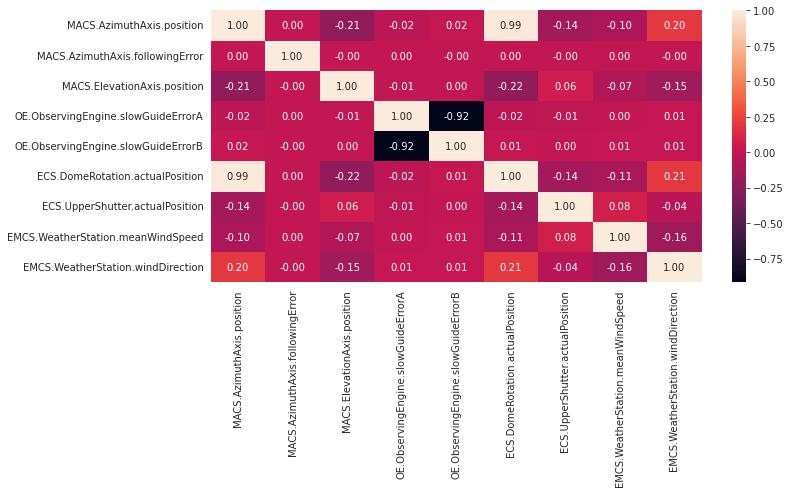

In [57]:
sns.heatmap(df_following_star.corr(), annot=True, fmt='.2f')
plt.show()

En esta gráfica se observa una depedencia de following error con : Azimuth 0.01, Elevation -0.08, Dome Rotation -0.08, UpperShutter 0.01, meanWindSpeed -0.1 y windDirection -0.01

La dependencia más alta es con velocidad del viento, pero sin embargo, esta dependencia es negativa, es decir, que cuando sube viento el following error baja, esto es extraño, ya que se espera lo contrario, podría ser que cuando sube el viento de cierto valor, el operador pone el telescopio a valores contrarios a la dirección del viento, por lo que habría que analizar en aquellos casos en que está alineado telescopio, con dirección del viento.

In [58]:
df_following_star['MACS.AzimuthAxis.position.bin']=pd.cut(x=df_following_star['MACS.AzimuthAxis.position'], bins=np.arange(0,360,10))
df_following_star['ECS.DomeRotation.actualPosition.bin']=pd.cut(x=df_following_star['ECS.DomeRotation.actualPosition'], bins=np.arange(0,360,10))
df_following_star['EMCS.WeatherStation.windDirection.bin']=pd.cut(x=df_following_star['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360,10))
df_following_star['MACS.AzimuthAxis.followingError.bin']=pd.cut(x=df_following_star['MACS.AzimuthAxis.followingError'], bins=np.arange(0,10,0.01))


In [59]:
df_following_star_align= df_following_star[ ( df_following_star['MACS.AzimuthAxis.position.bin'] == df_following_star['ECS.DomeRotation.actualPosition.bin'] ) &
( df_following_star['ECS.DomeRotation.actualPosition.bin'] == df_following_star['EMCS.WeatherStation.windDirection.bin'] )]

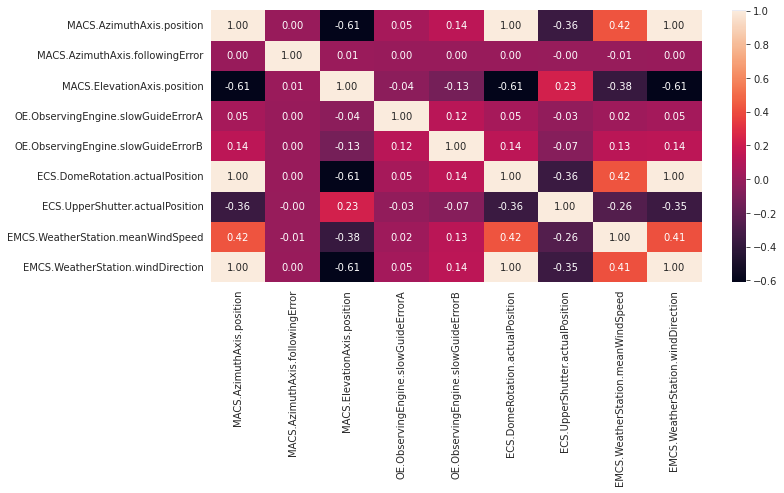

In [60]:
sns.heatmap(df_following_star_align.corr(), annot=True, fmt='.2f')
plt.show()

In [61]:
Parece que el following error aumenta con el viento, pero no los picos fuertes.

SyntaxError: invalid syntax (2617030170.py, line 1)

In [111]:
bins = pd.IntervalIndex.from_tuples( [ (-10, -8), (-8,-6) , (-6,-4) , (-4,-2) , (-2, 0) , (0, 2), (2,4) , (4,6) , (6,8) , (8, 10) ] )
df_following_star_align['MACS.AzimuthAxis.followingError.bin']=pd.cut(x=df_following_star_align['MACS.AzimuthAxis.followingError'], bins=np.arange(-0.5,0.5,0.05))
df_following_star_align['MACS.AzimuthAxis.followingError.bin'].value_counts(sort=False)

(-0.5, -0.45]           49
(-0.45, -0.4]           54
(-0.4, -0.35]          106
(-0.35, -0.3]          156
(-0.3, -0.25]          188
(-0.25, -0.2]          260
(-0.2, -0.15]          594
(-0.15, -0.1]         1331
(-0.1, -0.05]         3655
(-0.05, -1.11e-16]    7791
(-1.11e-16, 0.05]     8173
(0.05, 0.1]           3541
(0.1, 0.15]           1161
(0.15, 0.2]            526
(0.2, 0.25]            266
(0.25, 0.3]            200
(0.3, 0.35]            159
(0.35, 0.4]            101
(0.4, 0.45]             46
Name: MACS.AzimuthAxis.followingError.bin, dtype: int64

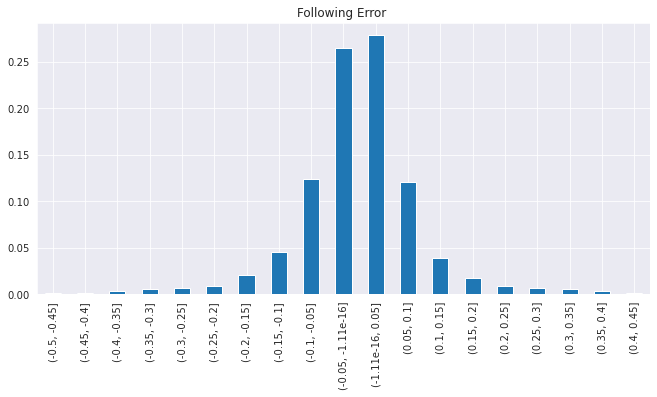

In [112]:
(df_following_star_align['MACS.AzimuthAxis.followingError.bin'].value_counts(sort=False)/df_following_star_align.shape[0]).plot(kind="bar");
plt.title("Following Error ");

In [96]:
df_following_star_align['MACS.AzimuthAxis.followingError.bin'].value_counts()

(1.78e-15, 0.1]     11713
(-0.1, 1.78e-15]    11447
(-0.2, -0.1]         1925
(0.1, 0.2]           1687
(0.2, 0.3]            466
(-0.3, -0.2]          448
(-0.4, -0.3]          262
(0.3, 0.4]            260
(-0.5, -0.4]          103
(0.4, 0.5]             85
(-0.6, -0.5]           69
(0.6, 0.7]             64
(0.5, 0.6]             64
(-0.7, -0.6]           53
(-0.8, -0.7]           38
(0.7, 0.8]             36
(1.0, 1.1]             22
(-1.0, -0.9]           22
(0.8, 0.9]             21
(0.9, 1.0]             21
(1.2, 1.3]             19
(-1.2, -1.1]           19
(-0.9, -0.8]           18
(-1.3, -1.2]           17
(1.1, 1.2]             16
(-1.1, -1.0]           14
(-1.5, -1.4]           13
(-1.4, -1.3]           12
(1.4, 1.5]             11
(-1.6, -1.5]           10
(-1.8, -1.7]            9
(1.6, 1.7]              9
(1.3, 1.4]              9
(1.5, 1.6]              8
(1.7, 1.8]              6
(-2.0, -1.9]            6
(1.8, 1.9]              6
(-1.9, -1.8]            5
(-1.7, -1.6]

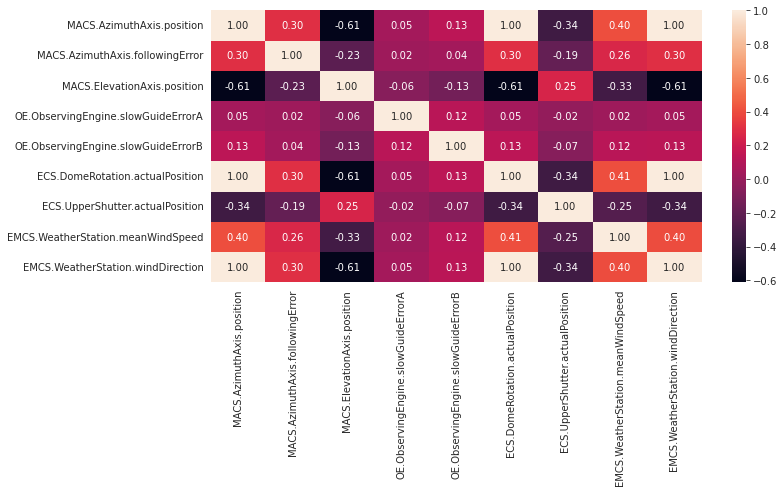

In [196]:
sns.heatmap(df_following_star_align [ df_following_star_align['MACS.AzimuthAxis.followingError.bin'] <= 3.0 ].corr(), annot=True, fmt='.2f')
plt.show()

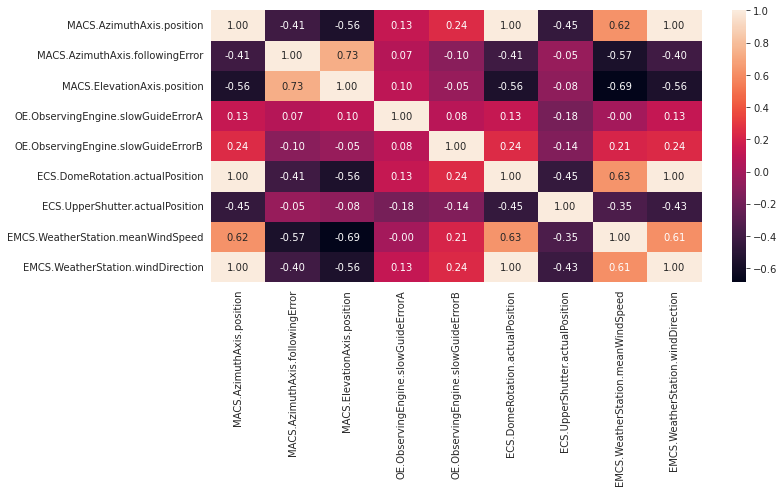

In [197]:
sns.heatmap(df_following_star_align[df_following_star_align['MACS.AzimuthAxis.followingError.bin'] > 3.0].corr(),
            annot=True, fmt='.2f')
plt.show()